# realtime_r0_brazil


## Visualizando a evolução do número de reprodução no Brasil

Vamos reproduzir o [modelo do Kevin Systrom](http://systrom.com/blog/the-metric-we-need-to-manage-covid-19/) para estimarmos $R_t$, o número de reprodução eficaz, para os estados brasileiros.

Começamos importando as bibliotecas necessárias. Condensamos boa parte do código no script `core.py`, para facilitar a utilização desse notebook.

In [1]:
# importing core 
# aqui empacotamos as funções que dá pra achar no código do Kevin Systrom
from core import run_full_model, load_data, plot_rt, plot_standings

# imports básicos
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

# importando joblib para rodar em paralelo
from joblib import Parallel, delayed

# para plots com uma melhor resolução
%config InlineBackend.figure_format = 'retina'

Área reservada para parâmetros do modelo. Até agora só deixamos aberto `N_JOBS`, para escolher o número de núvleos para o ajuste dos modelos.

In [2]:
### parâmetros ###

# númreo de cores para paralelizar modelo nos estados
N_JOBS = -1

### Leitura dos dados

Usamos o [repositório do Wesley Cota](https://github.com/wcota/covid19br) para pegar os dados mais atualizados por estado. 

In [3]:
### reading data ###

# lendo do repositório do Wesley Cota
city_df, state_df = load_data()



In [4]:
state_df

state     date      
Amazonas  2020-04-08     11
          2020-04-09     10
          2020-04-10     22
          2020-04-11     22
          2020-04-12     19
                       ... 
Ucayali   2020-04-16     49
          2020-04-17     56
          2020-04-18     73
          2020-04-19     97
          2020-04-20    120
Name: positive, Length: 662, dtype: int64

### Ajuste do modelo

Ajustamos um modelo bayesiano simples, assumindo que os dados de novos casos assumem uma distribuição Poisson parametrizada por $\lambda$ e a seguinte fórmula para a conexão entre $R_t$ e $\lambda$ ([segundo este artigo](https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0002185)):

$$ \lambda = k_{t-1}e^{\gamma(R_t-1)}$$

onde $\gamma$ é a recíproca do *serial interval* ([em torno de 7 dias para o COVID19](https://wwwnc.cdc.gov/eid/article/26/7/20-0282_article)) e $k_{t-1}$ é o número de novos casos para o dia anterior. Abaixo rodamos a função `run_full_model` para todos os estados em paralelo. Mais detalhes no [notebook do Kevin](https://github.com/k-sys/covid-19/blob/master/Realtime%20R0.ipynb).

In [5]:
### running posteriors ###

with Parallel(n_jobs=N_JOBS) as parallel:
    results = parallel(delayed(run_full_model)(grp[1], sigma=0.35) for grp in state_df.groupby(level='state'))

final_results = pd.concat(results)

### Observando os resultados: $R_t$

Usamos o mesmo padrão de visualização adotado pelo Kevin. Nos gráficos, cada ponto é a estimativa de $R_t$ para o dia, e a área cinzenta indica o intervalo crível de 90% de probabilidade. Deixamos $R = 1$ em evidência, já que quando $R_t < 1$ indica que a epidemia está sob controle.

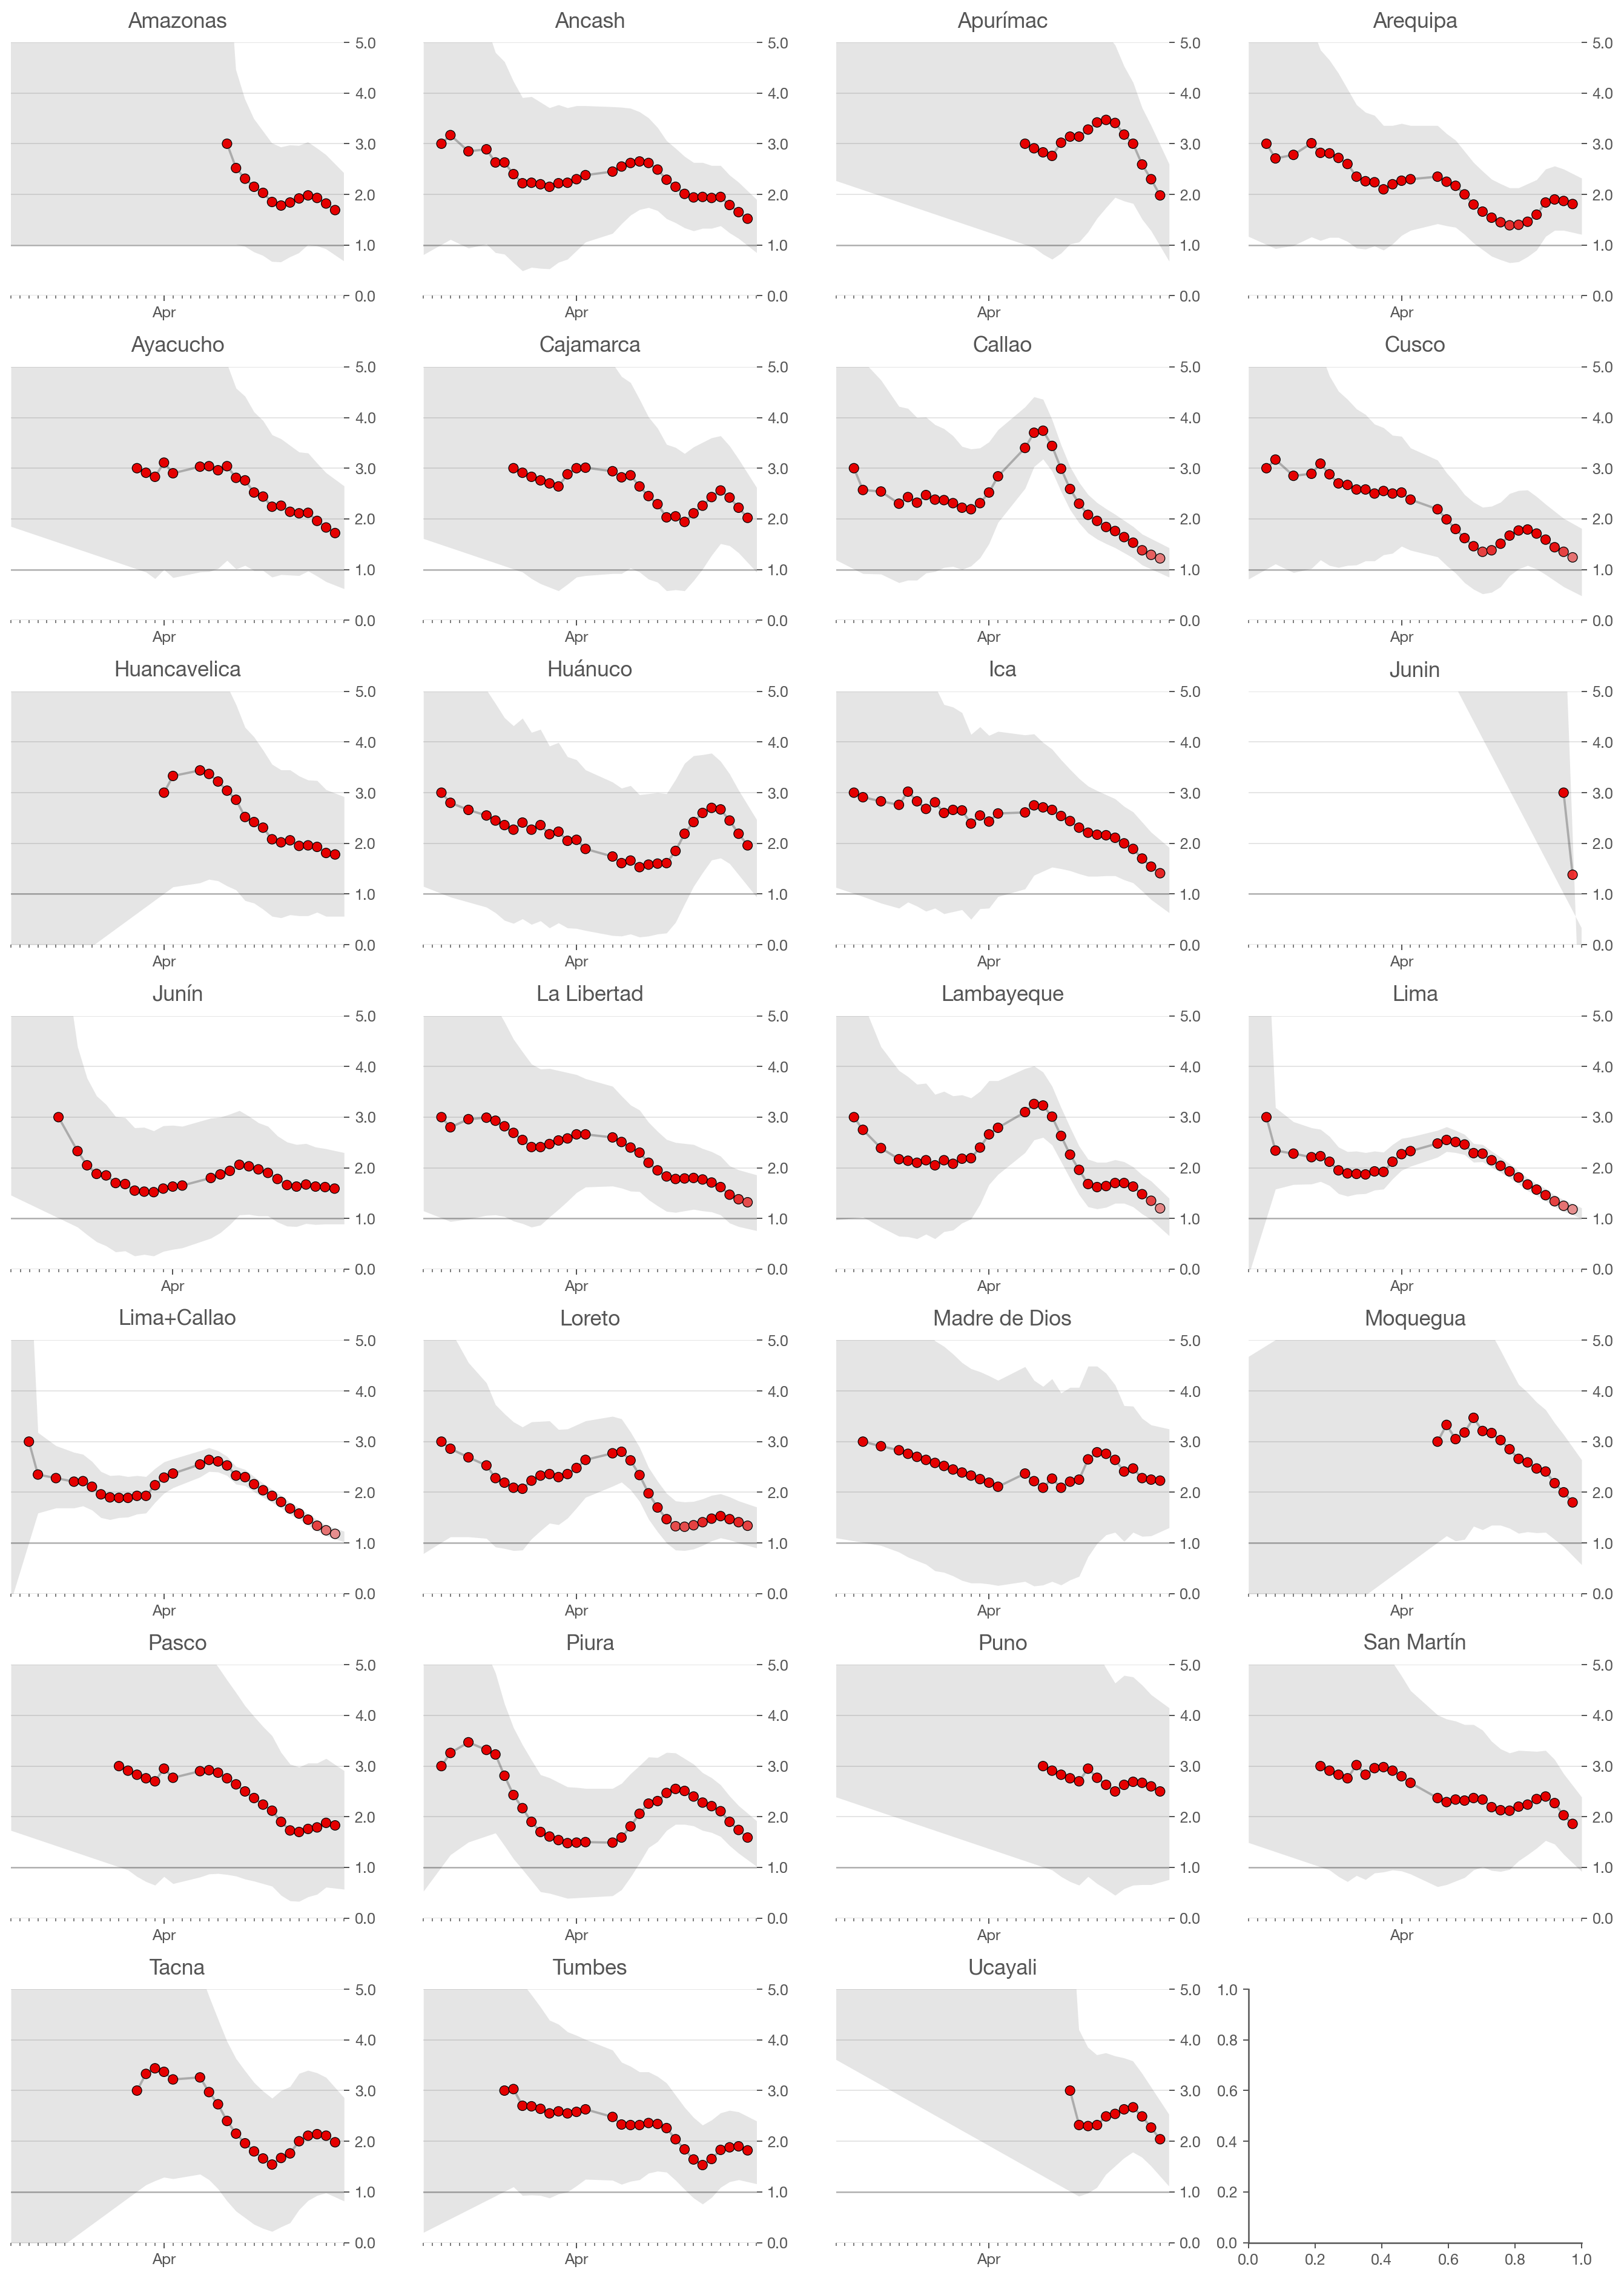

In [6]:
### plotting - Rt vs time for all states ###

def plot_rt_states():

    # number of columns and rows for plotting
    N_COLS = 4
    N_ROWS = int(np.ceil(len(results) / N_COLS))

    # opening figura
    fig, axes = plt.subplots(nrows=N_ROWS, ncols=N_COLS, figsize=(15, N_ROWS*3), dpi=90)

    # loop for several states
    for i, (state_name, result) in enumerate(final_results.groupby('state')):
        plot_rt(result, axes.flat[i], state_name)

    # saving figure
    fig.tight_layout()
    fig.set_facecolor('w')

plot_rt_states()

### Observando os resultados: comparação entre estados

Para fazer uma comparação entre estados, mostramos a última estimativa de $R_t$ de cada estado no gráfico de barras a seguir, com a incerteza associada. Os gráficos estão ordenados do melhor para o pior usando a estimativa mais provável do modelo.

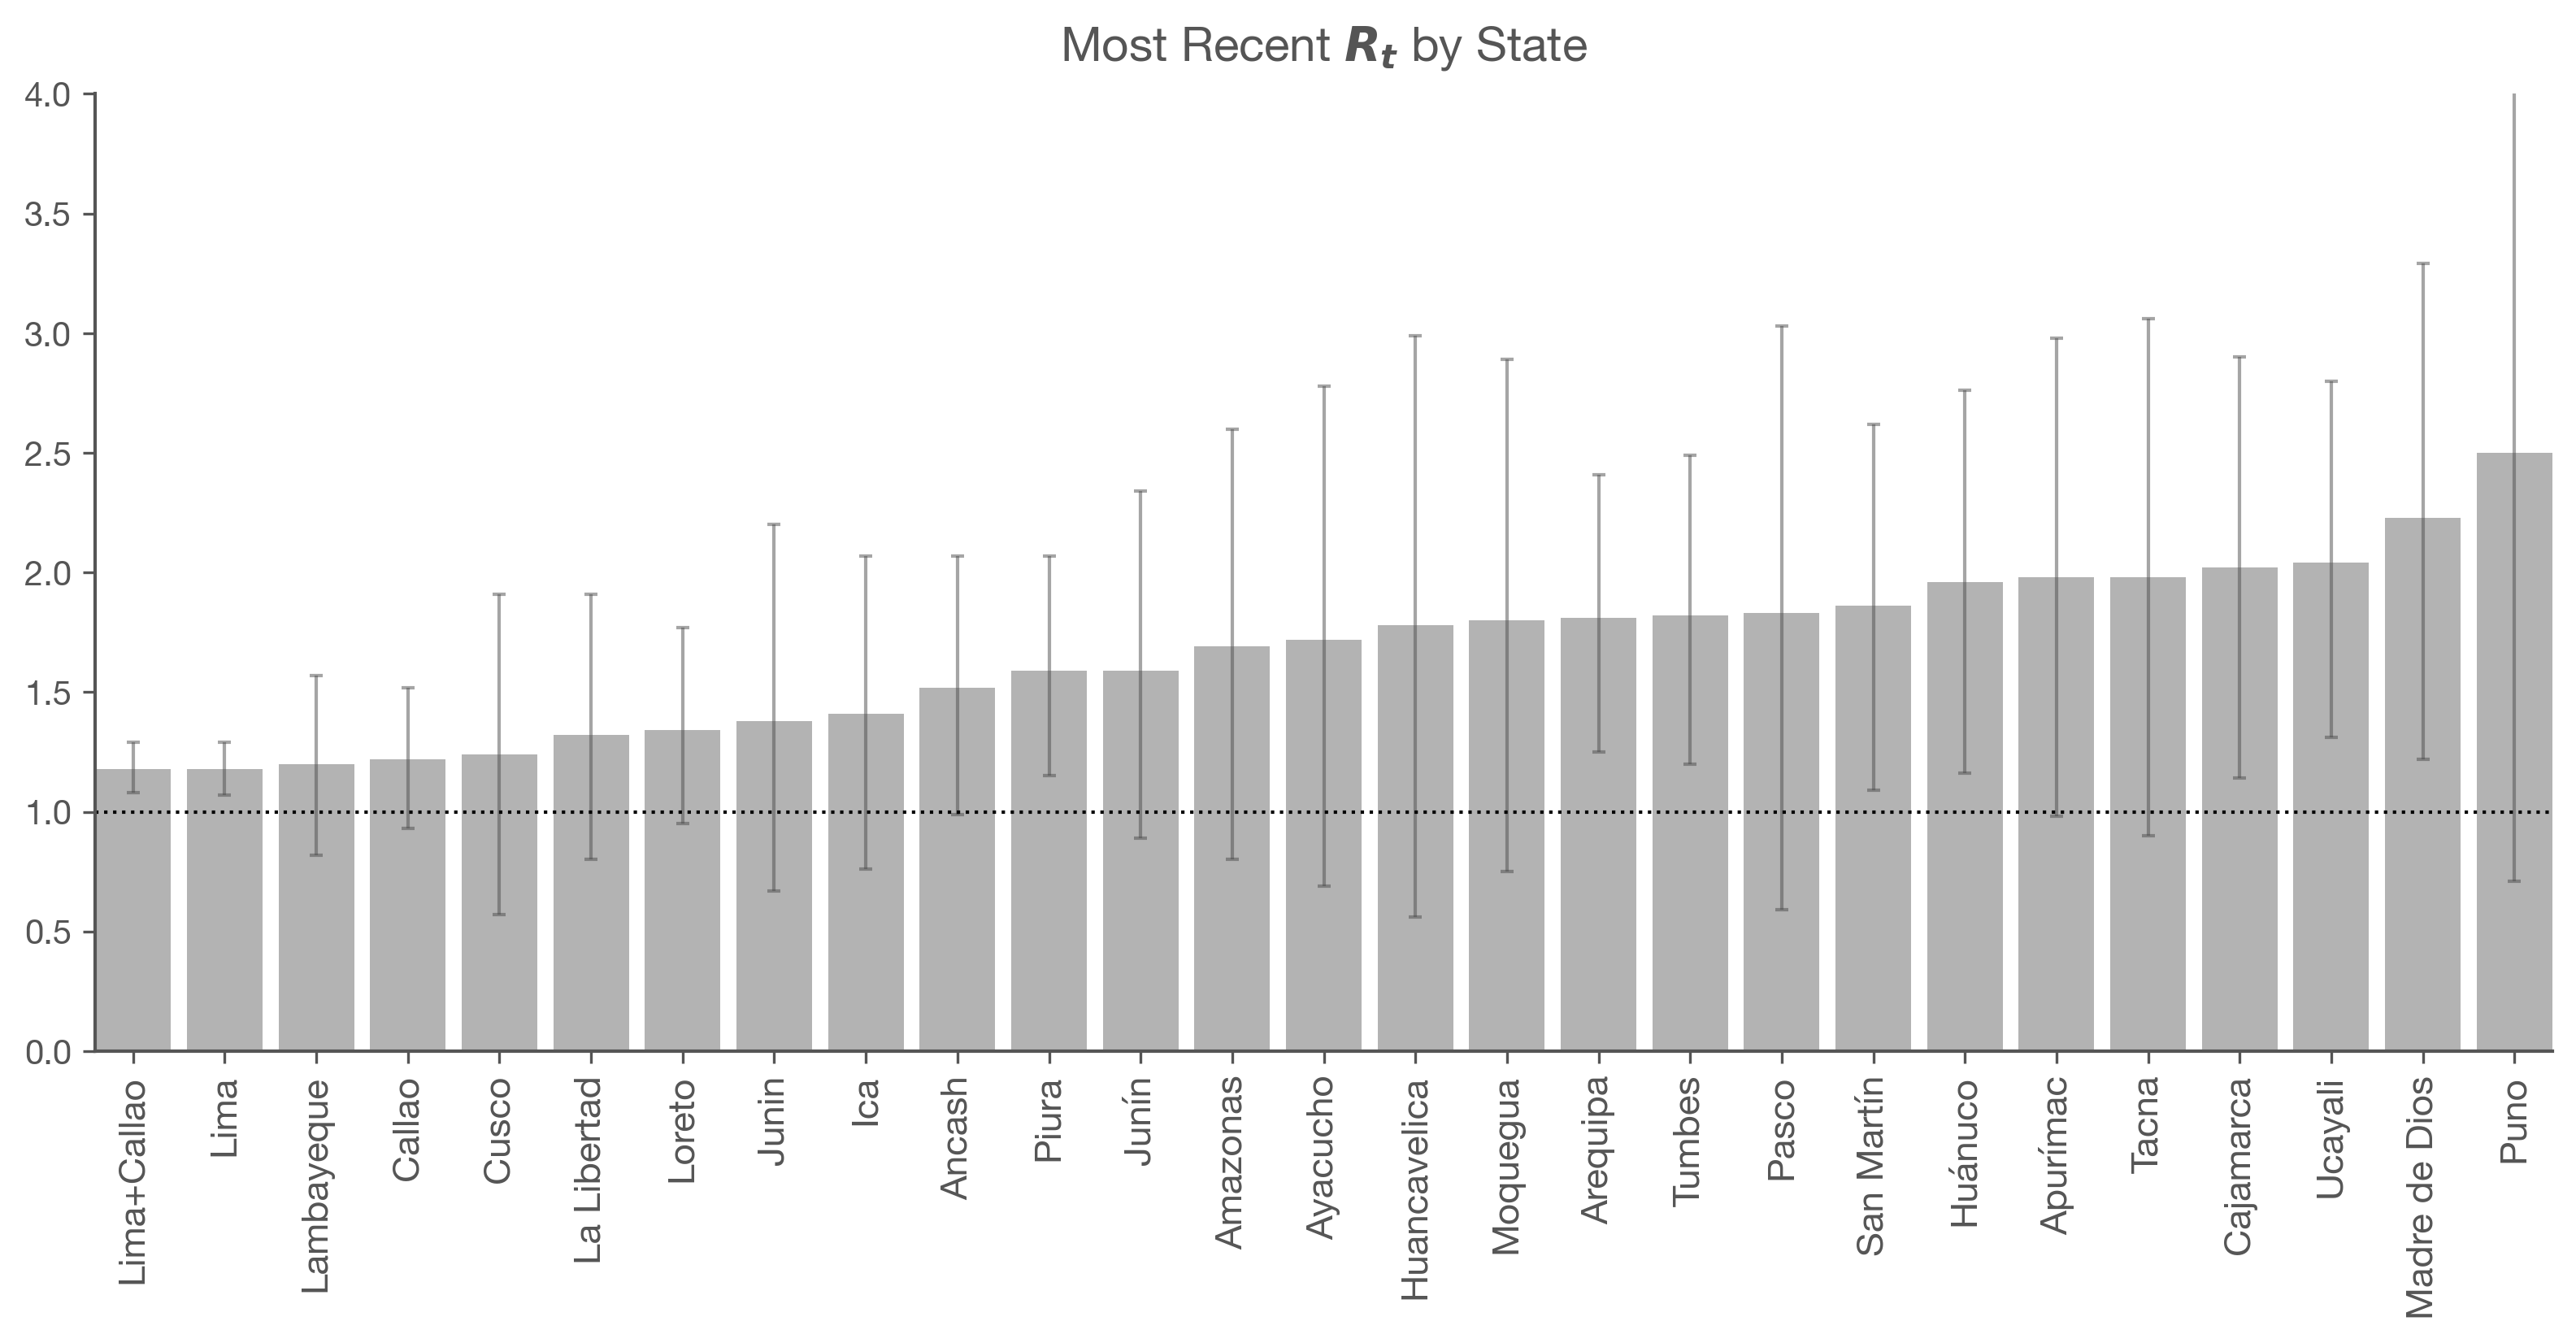

In [7]:
### plotting - state comparison ###

mr = final_results.groupby(level=0)[['ML', 'High_90', 'Low_90']].last()
mr.sort_values('ML', inplace=True)
plot_standings(mr, figsize=(13,5));

Podemos ordenar também pelo pior caso possível também, usando nossas estimativas de incerteza:

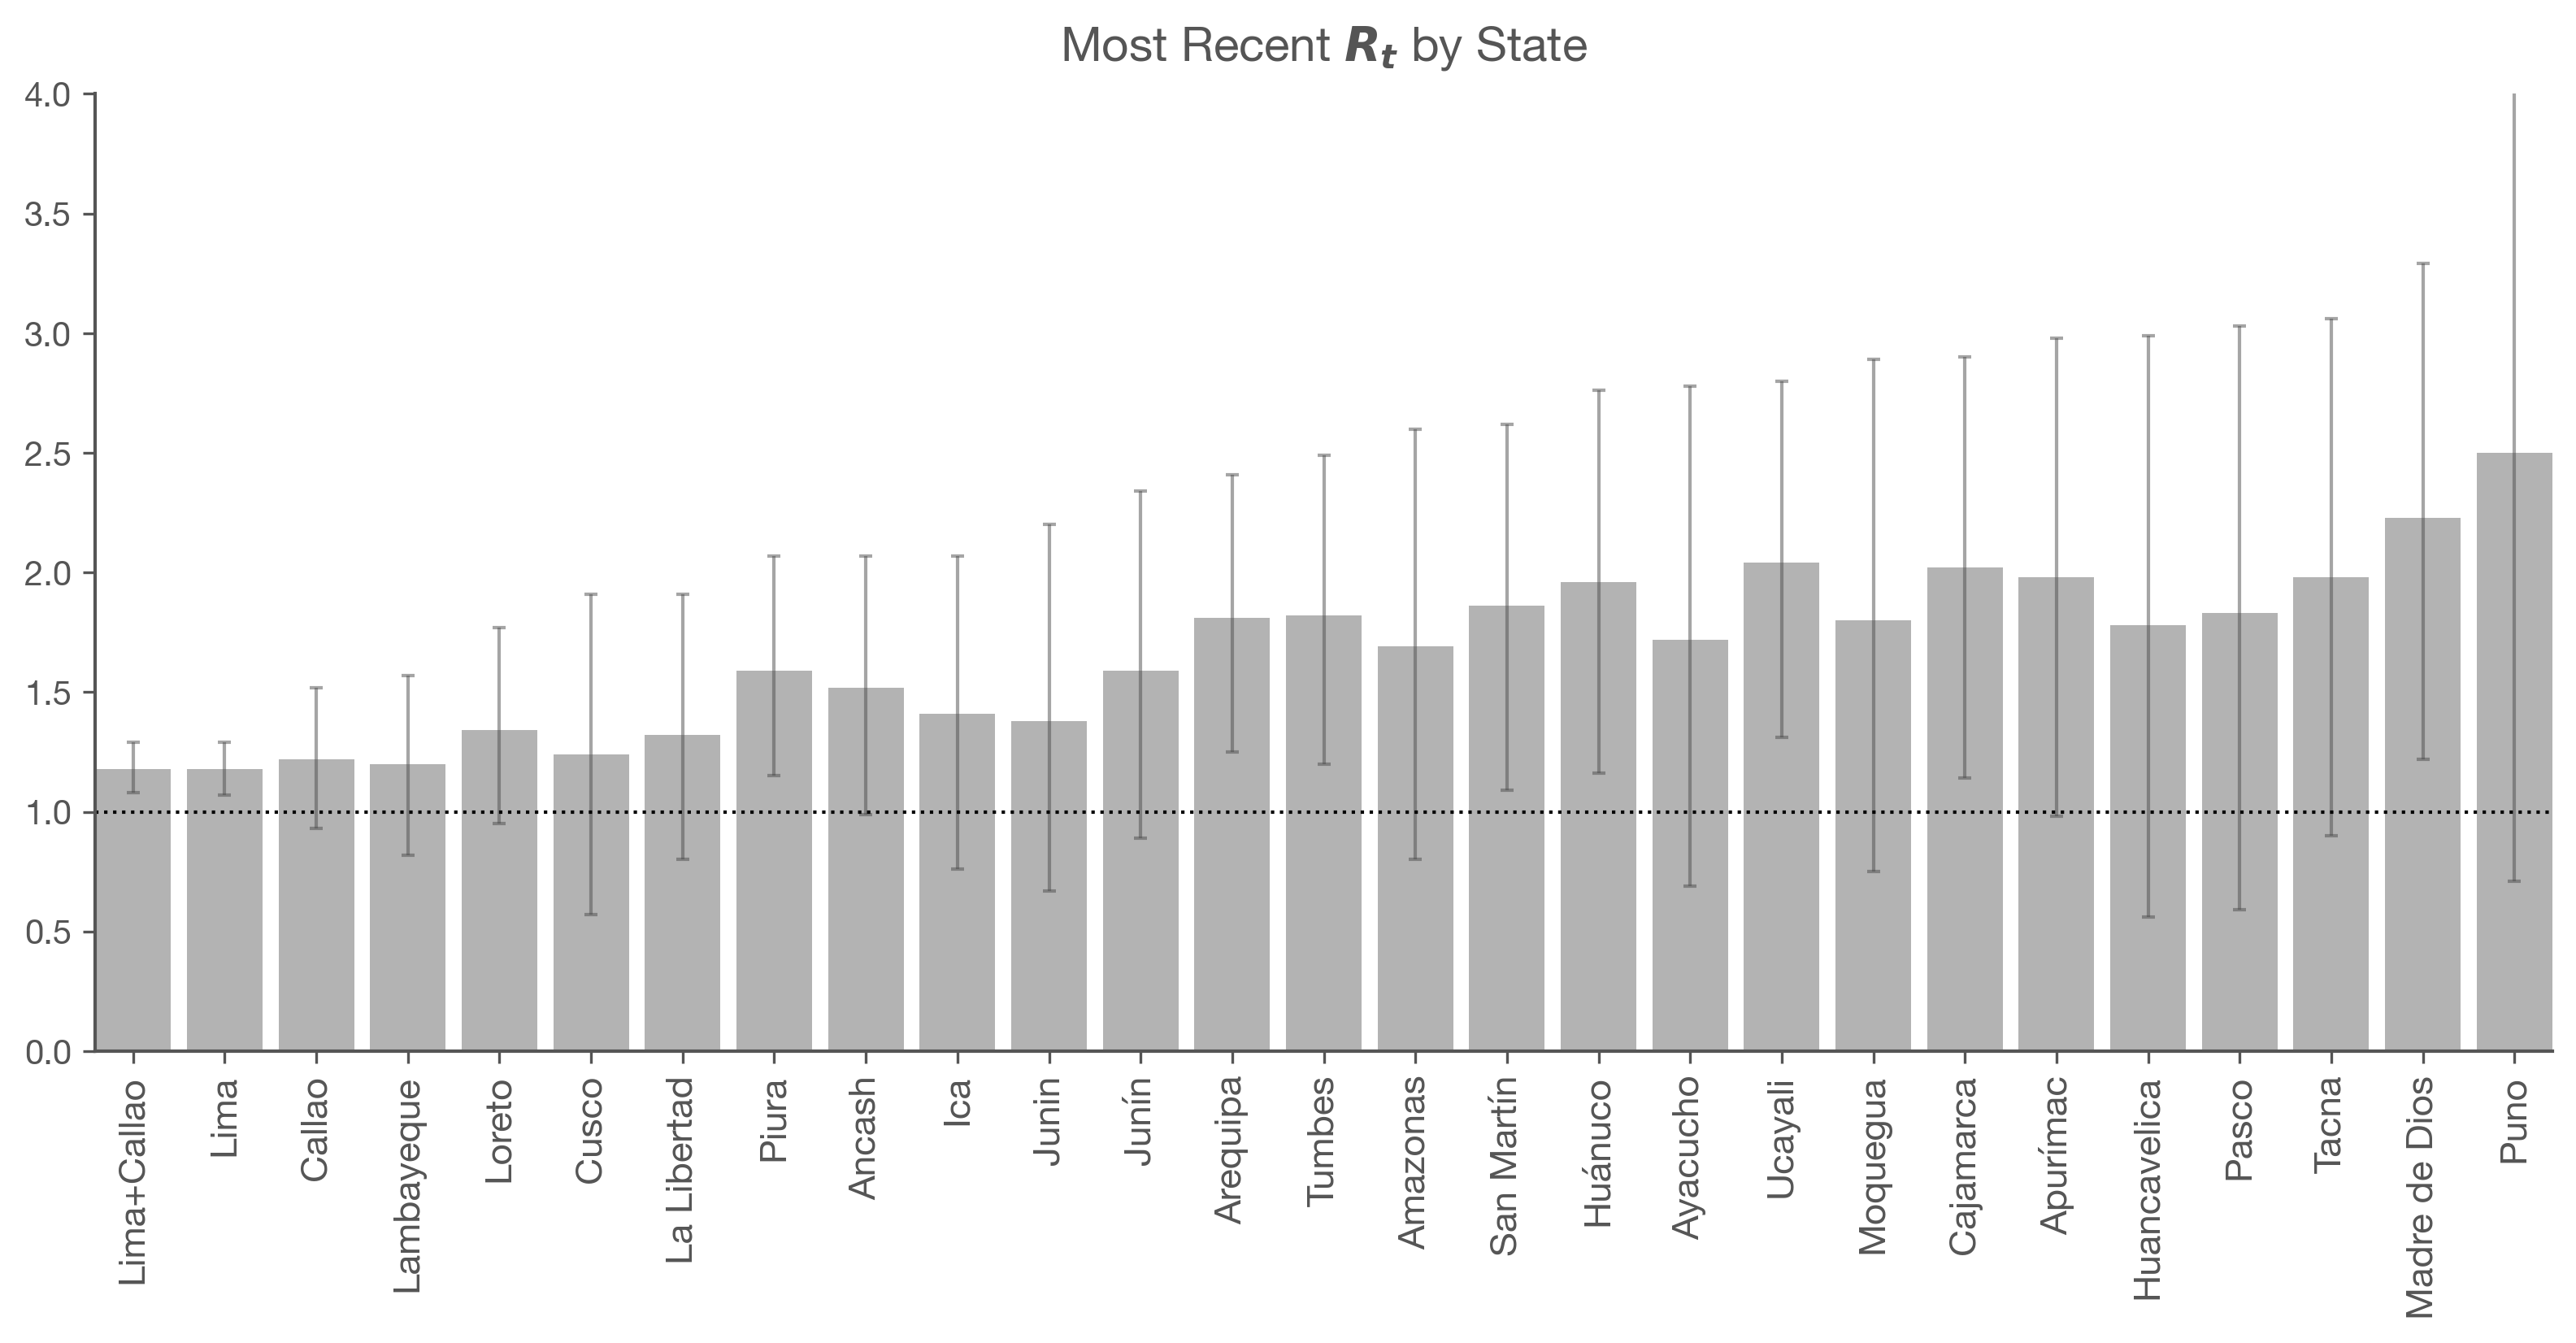

In [8]:
### ordering by worst case ##

mr.sort_values('High_90', inplace=True)
plot_standings(mr, figsize=(13,5));

In [9]:
final_results.to_csv('~/rt.csv')

In [13]:
final_results

ML  Low_90  High_90
state    date                             
Amazonas 2020-04-08  3.00    1.01     6.99
         2020-04-09  2.52    1.01     4.46
         2020-04-10  2.31    0.97     3.88
         2020-04-11  2.15    0.86     3.49
         2020-04-12  2.03    0.79     3.25
...                   ...     ...      ...
Ucayali  2020-04-16  2.63    1.66     3.64
         2020-04-17  2.67    1.78     3.58
         2020-04-18  2.49    1.68     3.34
         2020-04-19  2.27    1.51     3.07
         2020-04-20  2.04    1.31     2.80

[662 rows x 3 columns]

In [14]:
df = pd.read_csv('~/rt.csv')

In [21]:
df[df.state == 'Lima+Callao'].ML.to_list()

[3.0,
 2.35,
 2.28,
 2.21,
 2.22,
 2.11,
 1.96,
 1.9,
 1.89,
 1.89,
 1.93,
 1.93,
 2.14,
 2.29,
 2.37,
 2.5500000000000003,
 2.64,
 2.61,
 2.53,
 2.33,
 2.3000000000000003,
 2.16,
 2.04,
 1.93,
 1.81,
 1.68,
 1.58,
 1.46,
 1.34,
 1.25,
 1.18]

In [22]:
df[df.state == 'Lima+Callao'].Low_90.to_list()

[1.01,
 1.59,
 1.69,
 1.69,
 1.73,
 1.65,
 1.5,
 1.46,
 1.5,
 1.51,
 1.57,
 1.59,
 1.8,
 1.98,
 2.09,
 2.3000000000000003,
 2.41,
 2.4,
 2.33,
 2.16,
 2.13,
 2.01,
 1.9,
 1.8,
 1.69,
 1.56,
 1.47,
 1.35,
 1.24,
 1.14,
 1.08]

In [23]:
df[df.state == 'Lima+Callao'].High_90.to_list()

[6.99,
 3.18,
 2.92,
 2.79,
 2.75,
 2.61,
 2.41,
 2.33,
 2.34,
 2.31,
 2.33,
 2.31,
 2.47,
 2.6,
 2.66,
 2.82,
 2.88,
 2.82,
 2.71,
 2.51,
 2.45,
 2.31,
 2.18,
 2.06,
 1.94,
 1.8,
 1.7,
 1.57,
 1.46,
 1.35,
 1.29]